# Explore openSMILE

This notebook will explore the [openSMILE](https://audeering.github.io/opensmile-python/) Python interface to extract vocal features from audio. To run the notebook the `opensmile` package needs to be installed: Run a command prompt as administrator and then enter `pip install opensmile`.

When FFmpeg is not installed, openSMILE expects audio file in mono PCM `.wav` format. It extracts different pre-defined feature sets (see this [link](https://coder.social/audeering/opensmile-python) for a comparison) that can be applied on three different levels: Low-level descriptors, functionals, and low-level descriptor deltas. It is also possible to supply a custom configuration file for feature extraction.

In [1]:
import opensmile
import pandas as pd
import matplotlib.pyplot as plt

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


## Single Speaker

As a test case for a single speaker, a part of the victory speech by the current president of the United States Joe Biden will be used ([link](https://www.englishspeecheschannel.com/english-speeches/joe-biden-speech/) to full speech). This audio file is located at `/audio`.

In [2]:
extractor = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors
)

In [3]:
extractor.feature_names

['Loudness_sma3',
 'alphaRatio_sma3',
 'hammarbergIndex_sma3',
 'slope0-500_sma3',
 'slope500-1500_sma3',
 'spectralFlux_sma3',
 'mfcc1_sma3',
 'mfcc2_sma3',
 'mfcc3_sma3',
 'mfcc4_sma3',
 'F0semitoneFrom27.5Hz_sma3nz',
 'jitterLocal_sma3nz',
 'shimmerLocaldB_sma3nz',
 'HNRdBACF_sma3nz',
 'logRelF0-H1-H2_sma3nz',
 'logRelF0-H1-A3_sma3nz',
 'F1frequency_sma3nz',
 'F1bandwidth_sma3nz',
 'F1amplitudeLogRelF0_sma3nz',
 'F2frequency_sma3nz',
 'F2bandwidth_sma3nz',
 'F2amplitudeLogRelF0_sma3nz',
 'F3frequency_sma3nz',
 'F3bandwidth_sma3nz',
 'F3amplitudeLogRelF0_sma3nz']

In [4]:
features_single_df = extractor.process_file("audio/test_audio_single.wav")

In [5]:
print(features_single_df["F0semitoneFrom27.5Hz_sma3nz"])

file                         start                   end                   
audio/test_audio_single.wav  0 days 00:00:00         0 days 00:00:00.020000    37.153427
                             0 days 00:00:00.010000  0 days 00:00:00.030000    37.187588
                             0 days 00:00:00.020000  0 days 00:00:00.040000    37.305878
                             0 days 00:00:00.030000  0 days 00:00:00.050000    37.563763
                             0 days 00:00:00.040000  0 days 00:00:00.060000    37.740345
                                                                                 ...    
                             0 days 00:00:29.910000  0 days 00:00:29.930000    25.055805
                             0 days 00:00:29.920000  0 days 00:00:29.940000    25.066771
                             0 days 00:00:29.930000  0 days 00:00:29.950000    25.088697
                             0 days 00:00:29.940000  0 days 00:00:29.960000    23.766296
                             0 day

In [6]:
def plot_feature_over_time(features_df, feature_name):
    plot_df = features_df.reset_index()

    x = pd.to_timedelta(plot_df["start"])
    y = plot_df[feature_name]

    plt.plot(x, y)
    plt.show()

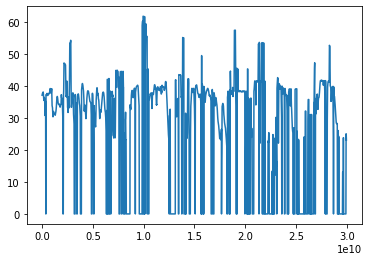

In [7]:
plot_feature_over_time(features_single_df, "F0semitoneFrom27.5Hz_sma3nz")

## Multiple speakers

As a test case for multiple speakers, a part of a presidential debate in the United States 2020  will be used ([link](https://www.englishspeecheschannel.com/english-speeches/us-presidential-debates-2020/) to full speech). The audio file is located at `/audio`.

In [8]:
features_multi_df = extractor.process_file("audio/test_audio_multi.wav")

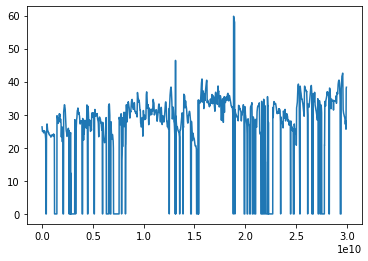

In [10]:
plot_feature_over_time(features_multi_df, "F0semitoneFrom27.5Hz_sma3nz")

## Custom Feature Sets

openSMILE also allows the user to supply a custom set of features. These can be specified in a `.config` file (see this [link](https://audeering.github.io/opensmile/reference.html#configuration-files) for documentation). In this file, several components can be stacked to extract features from the raw audio stream. In this file, 5 components are included:
- `cFramer`: Splits the audio signal into frames
- `cTransformFFT`: Applies the FFT to the frames
- `cFFTmagphase`: Computes the magnitude and phase of the FFT signal
- `cAcf`: Computes the ACF from the magnitude spectrum
- `cPitchACF`: Computes the fundamental frequency (F0) from the ACF

Each component receives the output of the previous component as input.

In [106]:
config_str = """

;;; Source
[componentInstances:cComponentManager]
instance[dataMemory].type=cDataMemory

\{\cm[source{?}:include external source]}

;;; Main section
[componentInstances:cComponentManager]
instance[framer].type = cFramer
instance[fft_trans].type = cTransformFFT
instance[fft_magphase].type = cFFTmagphase
instance[acf].type = cAcf
instance[pitch_acf].type = cPitchACF

;;; Split input signal into frames
[framer:cFramer]
reader.dmLevel = wave
writer.dmLevel = frames
copyInputName = 1
frameMode = fixed
frameSize = 0.02
frameStep = 0.02
frameCenterSpecial = left
noPostEOIprocessing = 1

;;; Apply FFT to frame signal
[fft_trans:cTransformFFT]
reader.dmLevel = frames
writer.dmLevel = fft_trans

;;; Compute magnitude and phase of FFT signal
[fft_magphase:cFFTmagphase]
reader.dmLevel = fft_trans
writer.dmLevel = fft_magphase

;;; Compute autocorrelation function from magnitude signal
[acf:cAcf]
reader.dmLevel = fft_magphase
writer.dmLevel = acf

;;; Compute voice pitch from ACF
[pitch_acf:cPitchACF]
reader.dmLevel = acf
writer.dmLevel = pitch_acf
F0 = 1

;;; Sink
\{\cm[sink{?}:include external sink]}

"""

In [107]:
with open('custom.conf', 'w') as file:
    file.write(config_str)

In [108]:
extractor_custom = opensmile.Smile(
    feature_set="custom.conf",
    feature_level="pitch_acf"
)

In [109]:
features_custom_df = extractor_custom.process_file("audio/test_audio_multi.wav")

In [111]:
print(features_custom_df)

                                                                          voiceProb  \
file                       start                  end                                 
audio/test_audio_multi.wav 0 days 00:00:00        0 days 00:00:00.020000   0.474689   
                           0 days 00:00:00.020000 0 days 00:00:00.040000   0.603376   
                           0 days 00:00:00.040000 0 days 00:00:00.060000   0.667886   
                           0 days 00:00:00.060000 0 days 00:00:00.080000   0.701862   
                           0 days 00:00:00.080000 0 days 00:00:00.100000   0.764631   
...                                                                             ...   
                           0 days 00:00:29.900000 0 days 00:00:29.920000   0.510440   
                           0 days 00:00:29.920000 0 days 00:00:29.940000   0.501227   
                           0 days 00:00:29.940000 0 days 00:00:29.960000   0.823150   
                           0 days 00:00:29.

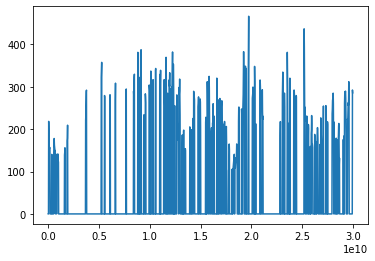

In [112]:
plot_feature_over_time(features_custom_df, "F0")